In [31]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score, label_ranking_average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score, label_ranking_average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm, preprocessing
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def standard_name(row):
    return row.replace('-', '').replace(' ', '').lower().strip()

In [3]:
# get subset of EARM only
ic50_data = pd.read_csv('data/GDSC1_fitted_dose_response_25Feb20.csv.gz')
# ic50_data = pd.read_excel('data/GDSC2_fitted_dose_response_25Feb20.xlsx')
ic50_data.head()

In [14]:
ic50_data.head()

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC2,282,13320532,749709,hcc1954,SIDM00872,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,-0.251083,0.975203,0.112373,0.906631
1,GDSC2,282,13320565,749710,hcc1143,SIDM00866,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,1.343315,0.978464,0.067577,1.683567
2,GDSC2,282,13320598,749711,hcc1187,SIDM00885,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,1.736985,0.995100,0.045205,1.875399
3,GDSC2,282,13320631,749712,hcc1395,SIDM00884,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,-2.309078,0.867832,0.107282,-0.096212
4,GDSC2,282,13320668,749713,hcc1599,SIDM00877,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,-3.106684,0.777532,0.098286,-0.484878


In [3]:
ic50_data['CELL_LINE_NAME'] = ic50_data.CELL_LINE_NAME.apply(standard_name)
cell_lines_in_ic50 = set(ic50_data.CELL_LINE_NAME.unique())

In [4]:
cell_lines_in_ic50

{'22rv1',
 '2313287',
 '42mgba',
 '5637',
 '639v',
 '647v',
 '697',
 '769p',
 '7860',
 '8305c',
 '8505c',
 '8mgba',
 'a101d',
 'a172',
 'a204',
 'a2058',
 'a253',
 'a2780',
 'a375',
 'a3kaw',
 'a427',
 'a498',
 'a4fuk',
 'a549',
 'a673',
 'a704',
 'abc1',
 'achn',
 'ags',
 'allpo',
 'allsil',
 'am38',
 'amo1',
 'an3ca',
 'arh77',
 'ash3',
 'aspc1',
 'atn1',
 'au565',
 'ball1',
 'bb49hnc',
 'bc1',
 'bcpap',
 'be13',
 'be2m17',
 'becker',
 'bftc905',
 'bftc909',
 'bht101',
 'bicr10',
 'bicr22',
 'bicr78',
 'bl41',
 'bph1',
 'bt20',
 'bt474',
 'bt483',
 'bt549',
 'bv173',
 'bxpc3',
 'c2bbe1',
 'c32',
 'c33a',
 'c3a',
 'c4i',
 'ca46',
 'ca922',
 'cadoes1',
 'cal120',
 'cal148',
 'cal27',
 'cal29',
 'cal33',
 'cal39',
 'cal51',
 'cal54',
 'cal62',
 'cal72',
 'cal78',
 'cal851',
 'calu3',
 'calu6',
 'cama1',
 'caov4',
 'capan1',
 'capan2',
 'car1',
 'cas1',
 'caski',
 'cck81',
 'ccrfcem',
 'cess',
 'cfpac1',
 'cgthw1',
 'chl1',
 'chp134',
 'chp212',
 'chsa8926',
 'cl11',
 'cl34',
 'cl40',
 '

In [5]:
rna_data = pd.read_csv('data/rna_celline.tsv.gz', delimiter='\t')
rna_raw = rna_data.groupby(['Cell line', 'Gene name']).mean().reset_index()

gene_names = rna_raw['Gene name'].unique()
rna_raw['Cell line'] = rna_data['Cell line'].apply(standard_name)

rna_raw = rna_raw.pivot(index='Cell line', values='TPM', columns='Gene name')
rna_raw.head(5)

cell_lines_in_rna = set(rna_raw.index)
print(len(cell_lines_in_rna))

64


In [61]:
cell_lines_in_rna

{'a431',
 'a549',
 'af22',
 'an3ca',
 'ascdiff',
 'asctert1',
 'bewo',
 'bj',
 'bjhtert+',
 'bjhtert+sv40larget+',
 'bjhtert+sv40larget+rasg12v',
 'caco2',
 'capan2',
 'daudi',
 'efo21',
 'fhdf/tert166',
 'hacat',
 'hap1',
 'hbec3kt',
 'hbftert88',
 'hdlm2',
 'hek293',
 'hel',
 'hela',
 'hepg2',
 'hhstec',
 'hl60',
 'hmc1',
 'hskmc',
 'htcepi',
 'htec/svtert24b',
 'hterthme1',
 'huvectert2',
 'k562',
 'karpas707',
 'lhcnm2',
 'mcf7',
 'molt4',
 'nb4',
 'ntera2',
 'pc3',
 'reh',
 'rh30',
 'rpmi8226',
 'rptectert1',
 'rt4',
 'sclc21h',
 'shsy5y',
 'siha',
 'skbr3',
 'skmel30',
 't47d',
 'thp1',
 'time',
 'u138mg',
 'u2197',
 'u251mg',
 'u266/70',
 'u266/84',
 'u2os',
 'u698',
 'u87mg',
 'u937',
 'wm115'}

In [6]:
in_both = cell_lines_in_ic50.intersection(cell_lines_in_rna)
print(len(in_both))

21


In [7]:
in_both

{'a549',
 'an3ca',
 'capan2',
 'daudi',
 'efo21',
 'hdlm2',
 'hel',
 'hela',
 'hl60',
 'k562',
 'mcf7',
 'molt4',
 'pc3',
 'reh',
 'rpmi8226',
 'rt4',
 'siha',
 't47d',
 'u2os',
 'u87mg',
 'wm115'}

In [9]:
drug_names = set(ic50_data.DRUG_NAME.unique())
# print(drug_names)
stats = []
for i in drug_names:
    cl_in_ic = set(ic50_data[ic50_data.DRUG_NAME == i]['CELL_LINE_NAME'].unique())
    stats.append([i, len(cl_in_ic.intersection(cell_lines_in_rna))])
df = pd.DataFrame(stats, columns=['drug', 'num_overlap'] )
df.sort_values('num_overlap', inplace=True)

In [10]:
df.tail(5)

In [142]:
in_both = set(ic50_data.CELL_LINE_NAME.unique()).intersection(set(rna_raw.index))

# filter
rna_copy = rna_raw.loc[rna_raw.index.isin(in_both)].copy()
good_std = list(rna_copy.std()[rna_copy.std() > 500].index.values)
print(len(good_std))
# rna_copy = rna_copy[good_std]

163


In [143]:
ic50_subset = ic50_data.loc[ic50_data.CELL_LINE_NAME.isin(in_both)]
drug_names = set(ic50_subset.DRUG_NAME.unique())

In [144]:
ic50_subset = pd.pivot_table(ic50_subset, index='CELL_LINE_NAME', columns='DRUG_NAME', values='LN_IC50')

In [145]:

ic50_subset.head(5)

DRUG_NAME,5-Fluorouracil,ABT737,AGI-5198,AGI-6780,AMG-319,AT13148,AZ6102,AZ960,AZD1208,AZD1332,...,Vorinostat,WEHI-539,WIKI4,WZ4003,Wee1 Inhibitor,Wnt-C59,XAV939,YK-4-279,ZM447439,Zoledronate
CELL_LINE_NAME,,,,,,,,,,,,,,,,,,,,,
a549,2.298731,3.120420,5.075185,3.104602,5.083600,1.934725,1.240829,1.071841,5.731266,2.165362,...,0.863150,5.301357,2.960920,2.696123,2.131678,2.818625,4.083935,1.597079,NaN,4.630658
an3ca,5.806868,3.807816,5.415285,3.849195,4.426382,2.511832,2.199036,0.309844,5.311958,0.502244,...,2.565052,5.072689,4.793249,4.870521,1.519083,3.509211,3.208779,3.252136,NaN,3.392397
capan2,8.045047,1.565612,5.765661,4.456088,6.497260,6.771240,2.831869,1.922611,7.228814,2.382968,...,4.095100,2.608404,3.947572,3.965499,6.028056,5.325523,4.388438,4.861982,NaN,5.296179
daudi,2.655478,1.884779,3.841348,2.765872,2.775433,3.553724,1.869841,0.166131,3.559133,2.729210,...,1.176439,2.762637,3.444306,2.291412,1.236726,3.737267,4.190365,2.556917,NaN,2.738602
efo21,7.514007,5.402121,7.080543,6.215425,5.786232,7.111423,3.326379,3.693820,6.962015,4.455673,...,4.906547,4.566885,5.675555,3.935434,6.001787,7.081433,6.186473,4.355078,NaN,6.174640


In [146]:
combined = rna_copy.join(ic50_subset)
combined.fillna(value=combined.mean(), inplace=True)
combined.head(5)

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,Vorinostat,WEHI-539,WIKI4,WZ4003,Wee1 Inhibitor,Wnt-C59,XAV939,YK-4-279,ZM447439,Zoledronate
Cell line,,,,,,,,,,,,,,,,,,,,,
a549,0.2,0.0,0.0,0.0,0.1,0.3,0.0,47.3,17.3,0.0,...,0.863150,5.301357,2.960920,2.696123,2.131678,2.818625,4.083935,1.597079,3.998881,4.630658
an3ca,0.3,0.0,0.7,0.0,0.0,0.3,0.0,45.2,31.3,0.4,...,2.565052,5.072689,4.793249,4.870521,1.519083,3.509211,3.208779,3.252136,3.998881,3.392397
capan2,0.1,0.0,1.8,0.1,0.1,0.0,0.0,32.2,25.6,7.2,...,4.095100,2.608404,3.947572,3.965499,6.028056,5.325523,4.388438,4.861982,3.998881,5.296179
daudi,0.5,0.0,1.1,0.0,0.0,13.3,0.0,58.4,11.0,0.0,...,1.176439,2.762637,3.444306,2.291412,1.236726,3.737267,4.190365,2.556917,3.998881,2.738602
efo21,0.0,0.0,10.9,0.0,0.9,0.0,0.0,17.6,10.8,0.0,...,4.906547,4.566885,5.675555,3.935434,6.001787,7.081433,6.186473,4.355078,3.998881,6.174640


In [147]:
gene_names

array(['A1BG', 'A1CF', 'A2M', ..., 'ZYG11B', 'ZYX', 'ZZEF1'], dtype=object)

0.5385795041618568
0.48432074687824145
1.3586895241729464
1.4548949719861073


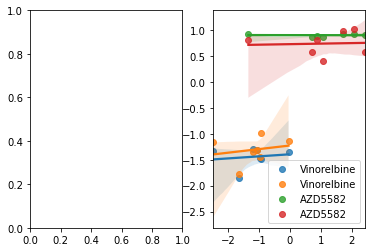

In [131]:
from sklearn.linear_model import ElasticNet



def run_model(df, drugname, save_name, model):
    subset_genes = list(sorted(set(gene_names).intersection(set(df.columns.values))))
    X = df[subset_genes].copy()
    y = df[drugname].values.reshape(-1, 1)
    X = preprocessing.StandardScaler(with_mean=False).fit_transform(X)
    y = preprocessing.StandardScaler(with_mean=False).fit_transform(y).ravel()
#     print(y)
#     return
#     poly = PolynomialFeatures(degree=2)
#     X = poly.fit_transform(X)
     
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.33, 
        shuffle=False, 
        random_state=69,
    )
    
#     print(X_train.shape, y_train.shape)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    error = mean_squared_error(y_test, preds)
#     print(np.max(model.coef_))
    
#     sns.regplot(y_train, model.predict(X_train), label='training', ax=ax1)
    sns.regplot(y_test, preds, label=i, ax=ax2)
#     plt.legend()
#     plt.suptitle(f"{drugname} {save_name} : RMSE = {error}")
    return error
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for i in list(drug_names)[:2]:
    error = run_model(
        combined, i,  'apoptosis_subset', 
        model=ElasticNet(random_state=0, normalize =False, max_iter=100000)
    )
    print(error)
    error = run_model(
        combined, i,  'apoptosis_subset', 
        model=svm.SVR(gamma=0.001, C=10.)
    )
    print(error)
    
plt.legend()

Epoch [1000/10000], Loss train: 5.9469e+00, test 1.9088e+00                         
	 1.479


1.4793539

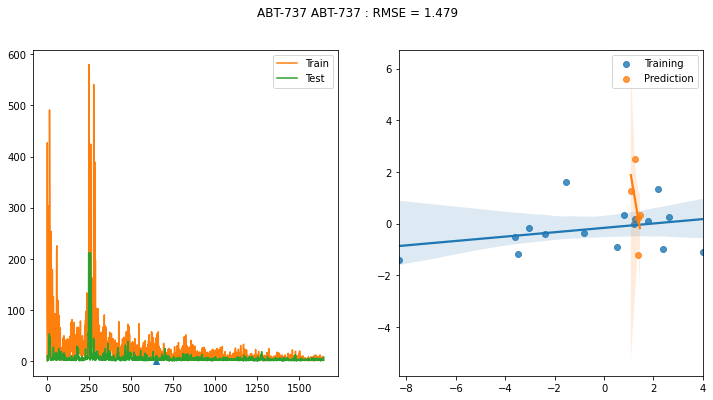

In [150]:
import torch
import torch.nn as nn
class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)
        self.dropout = nn.Dropout(p=0.5)
        self.Tanh = nn.Tanh()
    def forward(self, x):
        y_pred = self.dropout(self.linear1(x))
#         y_pred = self.dropout(self.Tanh(y_pred))
        y_pred = self.dropout(self.linear2(y_pred))
#         y_pred = self.dropout(self.Tanh(y_pred))
        return y_pred
    
import time
from copy import deepcopy
def run_nn(df, gene_list, save_name, drugname, verbose=False):
    torch.cuda.empty_cache()
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(drugname)
#     dev = 'cpu'
#     print('Using device:', dev)
    ib = list(set(gene_list).intersection(set(df.columns.values)))
    X = df[ib].values
    y = df[list(drug_names)[0]].values.reshape(-1,1)
    X = preprocessing.StandardScaler().fit(X).transform(X)
    y = preprocessing.StandardScaler().fit(y).transform(y)
#     poly = PolynomialFeatures(degree=2)
#     X = poly.fit_transform(X)
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size=0.2, 
            shuffle=True, 
            random_state=69,
        )
    except:
        return
    
    dtype = torch.float32
    X_train = torch.tensor(X_train, dtype=dtype,  device=dev)
    X_test = torch.tensor(X_test, dtype=dtype,  device=dev)

    y_train = torch.tensor(y_train, dtype=dtype,  device=dev)
    y_test = torch.tensor(y_test, dtype=dtype,  device=dev)

#     print(X_train.shape, y_train.shape)
    D_in, D_out = X_train.shape[1], y_train.shape[1]
    H1 = int((D_in+D_out)/2)
#     H1 = 100
    model = Net(D_in, H1, D_out)
    model.to(dev)
    model.float()
    criterion = nn.MSELoss(reduction='mean')
    
#     optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-4,
        betas=(0.9, 0.999), 
        eps=1e-08, 
        weight_decay=0,
        amsgrad=True
    )
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#     optimizer = torch.optim.ASGD(
#         model.parameters(), lr=0.01, lambd=0.001, 
#         alpha=0.0, t0=1000.0, weight_decay=0.
#     )

    n_epoch = 10000
    eval_per_epoch = n_epoch//10
    prev_loss = np.inf
    steps_wo_impro = 0
    best_state = deepcopy(model.state_dict())
    best_epoch = 0
    st = time.time()
    train, valid = [], []
    for epoch in range(n_epoch):
        if steps_wo_impro > eval_per_epoch:
#             print(f"Early stopping at {epoch}")
            break
        model.train()
        
        # use original method
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        if torch.isnan(loss):
            break        
        loss.backward()
        optimizer.step()
        with torch.no_grad():
        
            test_loss = criterion(model(X_test), y_test).item()

            train.append(loss.item())
            valid.append(test_loss)

            if test_loss < prev_loss:
                prev_loss = deepcopy(test_loss)
                steps_wo_impro = 0
                best_state = deepcopy(model.state_dict())
                best_epoch = epoch
            else:
                steps_wo_impro += 1
    #         if epoch < 1000:
    #             steps_wo_impro = 0
    #             prev_loss = np.inf
            if verbose:
                if (epoch+1) % eval_per_epoch == 0:
                    print(
                        'Epoch [{}/{}], Loss train: {:2.4e}, test {:2.4e} \
                        '.format(epoch+1, n_epoch, loss.item(), test_loss)
                    )
#     print(f'time : {time.time()-st}')
    del model
    
    test_model = Net(D_in, H1, D_out)
    test_model.load_state_dict(best_state)
    test_model.float()
    test_model.to(dev)
    test_model.eval()
    
    train_pred = test_model(X_train).cpu().detach().numpy()
    train_actual = y_train.cpu().detach().numpy()
    
    error = mean_squared_error(train_pred, train_actual)
    error = "{0:.3f}".format(np.sqrt(error))
#     print(f"Best epoch = {best_epoch} with error = {prev_loss} {np.sqrt(prev_loss)}")
#     print(f"\t {error}")  
    
    test_pred = test_model(X_test).cpu().detach().numpy()
    test_actual =  y_test.cpu().numpy()
    error = mean_squared_error(test_pred, test_actual)
#     return np.sqrt(error)
    error = "{0:.3f}".format(np.sqrt(error))
    
    print(f"\t {error}")  
    
    # simple plot
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    x_axis = range(0, len(train))
    plt.plot(best_epoch, prev_loss, marker='^')
    plt.plot(x_axis, train, label='Train')
    plt.plot(x_axis, valid, label='Test')
    plt.legend()

    plt.subplot(122)
    sns.regplot(train_pred[:,0], train_actual[:,0], label='Training')
    sns.regplot(test_pred[:,0], test_actual[:,0], label='Prediction')
    plt.legend()
    plt.suptitle(f"{drugname} {save_name} : RMSE = {error}")
#     plt.close()
    return np.sqrt(mean_squared_error(test_pred, test_actual))
run_nn(combined, gene_names, 'ABT-737', 'ABT-737', True) 

In [72]:
#%%

# fit model no training data
param = dict(
    # general params
    booster='gbtree',
    gpu_id=0,
    seed=100,
    # regularization
    reg_alpha=.1, 
    reg_lambda=1,
    
    tree_method='gpu_hist',
    max_bin=16,
    objective='reg:squarederror',
#     eval_metric='mlogloss',
#     eval_metric='rmse',
    learning_rate=0.2,
    max_depth=3, 
    min_child_weight=1,
    gamma=0,
    subsample=.8,
    colsample_bytree=.8,

)

#%%

def create_importance_model(df, drugname):
    X = df[gene_names]
    y = df['LN_IC50']

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.5, 
        shuffle=True, 
        random_state=123,
    )

    
    # organize data into xgb data matrix
    all_data = xgb.DMatrix(data=X, label=y)
    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)

    # add gene names as feature labels
    all_data.feature_names = gene_names
    train.feature_names = gene_names
    test.feature_names = gene_names
    num_round = 100
    model = xgb.train(param, train, num_round, verbose_eval=True)  
    
    #trained 
    preds = model.predict(train)
    plt.figure()
    sns.regplot(y_train, preds, label='training')
    
    preds = model.predict(test)
    error = mean_squared_error(y_test, preds)
    print("MSE: {0:.2f}".format(error))

    #predictions

    sns.regplot(y_test, preds, label='prediction')
    plt.legend()
    plt.title(f"{drugname} : {error}")

    plt.savefig(f'pred_{drugname}.png')
    return model

Palbociclib
(901, 19)
MSE: 4.78
MPS-1-IN-1
(916, 19)
MSE: 2.01
TWS119
(925, 19)
MSE: 2.04
MCT1_6447
(910, 19)
MSE: 1.35
Motesanib
(941, 19)
MSE: 0.62
FR-180204
(918, 19)
MSE: 1.16
CI-1033
(923, 19)
MSE: 1.10
PARP_0108
(930, 19)
MSE: 1.82
CCT007093
(936, 19)
MSE: 0.86
NVP-TAE684
(404, 19)
MSE: 1.87


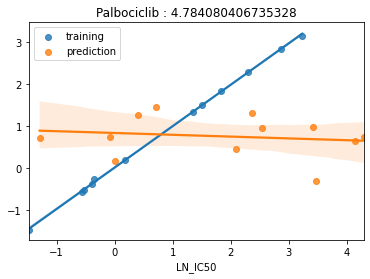

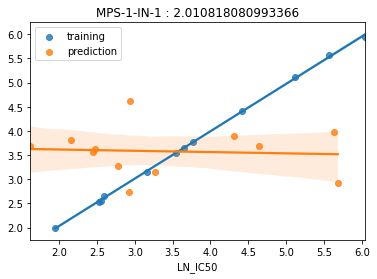

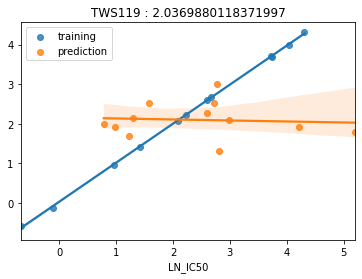

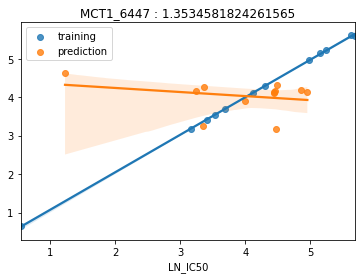

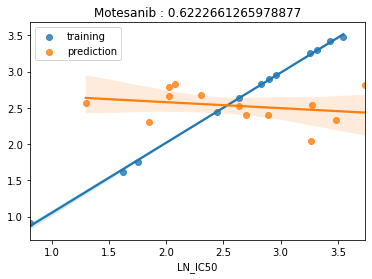

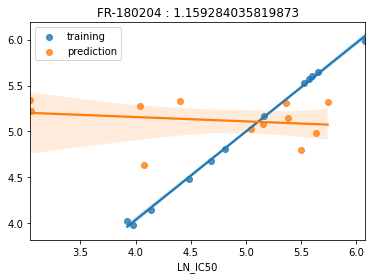

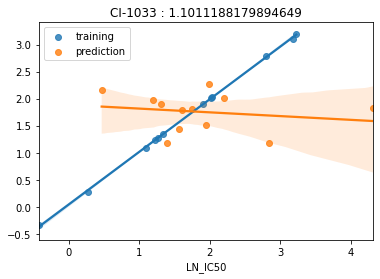

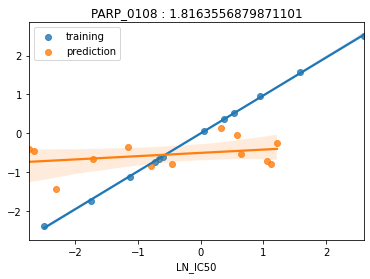

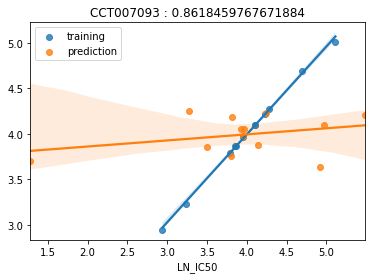

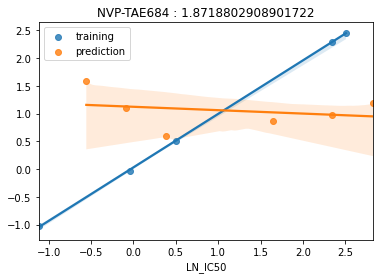

In [73]:
for i in list(drug_names)[:10]:
    print(i)
    ic50_subset = ic50_data.loc[ic50_data.DRUG_NAME.isin([i])]
    print(ic50_subset.shape)
    if ic50_subset.shape[0] == 0:
        continue
    else:
        # filter to only cell lines in both
        in_both = set(ic50_subset.CELL_LINE_NAME.unique()).intersection(set(rna_raw.index))

        # filter
        rna_copy = rna_raw.loc[rna_raw.index.isin(in_both)].copy()


        ic50_subset = ic50_subset.loc[ic50_subset.CELL_LINE_NAME.isin(in_both)]
        ic50_subset.set_index('CELL_LINE_NAME', inplace=True)

        # join
        combined = rna_copy.join(ic50_subset)
        model_1 = create_importance_model(combined, i)

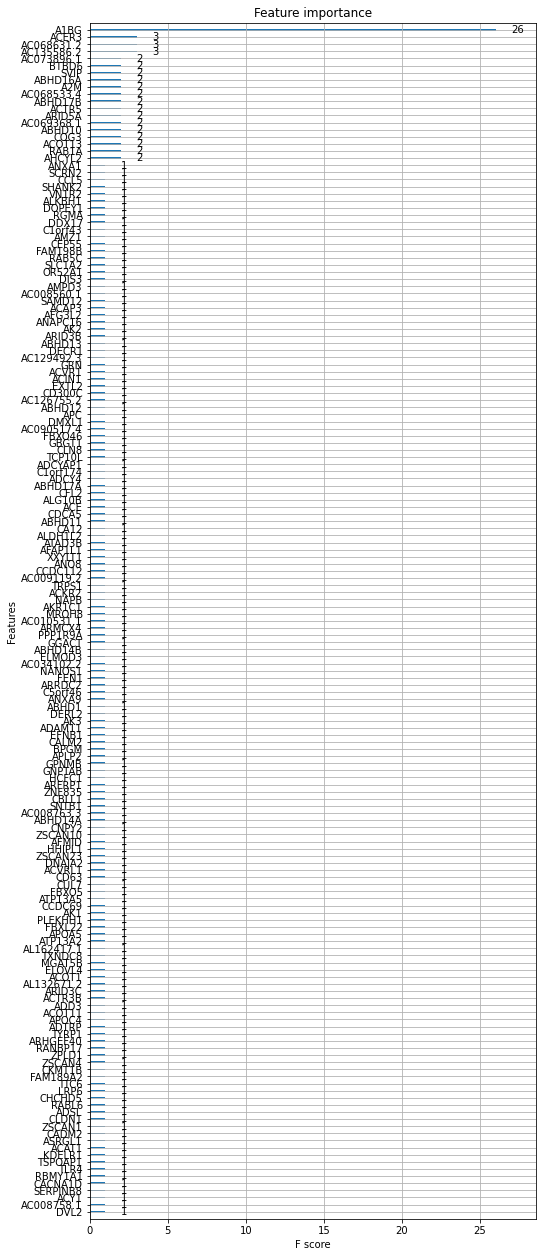

In [42]:
fig = plt.figure(figsize=(8,22))
ax = fig.add_subplot(111)
xgb.plot_importance(model_1, ax=ax)
plt.savefig("importance.png")